In [2]:
%matplotlib inline
import fitsio
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

FGAL =  '/Users/jh/Desktop/data/LRG_catalog/zGT070/selected_'
FMAP ={ 857:'/Users/jh/Desktop/data/Planck/HFI_SkyMap_857_2048_R2.02_full.fits',
       545:'/Users/jh/Desktop/data/Planck/HFI_SkyMap_545_2048_R2.02_full.fits'}
PCFIELD = {353:3, 545:4, 857:5}
FMAPMASKPLANE = '/Users/jh/Desktop/data/Planck/HFI_Mask_GalPlane-apo2_2048_R2.00.fits'
GALMAPMASK = '/Users/jh/Desktop/data/SDSS/mask_DR12v5_CMASS_North_512_galactic_x4.fits'
GALMAPMASKTHRESHOLD = 0.5
FMAPMASKPS = '/Users/jh/Desktop/data/Planck/HFI_Mask_PointSrc_2048_R2.00.fits'
PLANEMASKFIELD = {20:0, 40:1, 60:2, 70:3, 80:4}
u_coeff = 5.155
g_coeff = 3.793
r_coeff = 2.751

In [3]:
def cl_read(fn):
    f = open(fn)
    con = f.readlines()
    ell = []
    cl  = []
    for line in con:
        line = line.split()
        ell.append( int(line[0]) )
        cl.append( float(line[1]))
    return ell, cl

def cl_binned(l, cl, binSize): 
    nbins = len(l)/binSize
    l_bin = []
    cl_bin = []
    for ib in xrange(nbins):
        l_mid = ib*binSize + binSize/2 + l[0]
        elLs = range(ib*binSize+l[0],(ib+1)*binSize+l[0])
        modes = sum( 2*el +1 for el in elLs)
        cl_mid = sum( [ cl[el-l[0]] * (2*el +1.0) for el in elLs ] )/ modes
        l_bin.append(l_mid)
        cl_bin.append( cl_mid   )

    return l_bin, cl_bin

def cl_save(l, cl, fn):
    fw = open(fn, 'w')
    for i in xrange(len(cl)):
        fw.write("%i      %.10e \n"%(l[i], cl[i]))
    fw.flush()
    fw.close()
    return

def cl_plot(cl, binSize=1, lmin=0, style='bo', alpha=0.7, c='b', label=None):
    ell = np.arange(len(cl))
    ell_bin, cl_bin = cl_binned(ell[lmin:], cl[lmin:], binSize)
    fig, = plt.plot(ell_bin, cl_bin, style, alpha=alpha, c=c, label=label)
    return fig
    
def cross_alm(almIn1, almIn2, binSize=128, lmin=100, doPlot=True, title="", xlabel='$l$',\
              ylabel='$C_l$ (Jy / sr)', style='bs', c='b', label=None):
    """ if the inputs are file names, read the .alm files and do the cross correlation.
        if the inputs are ndarray of alm data, do the cross correlation directly.
    """
    
    if type(almIn1).__name__ == 'str' and type(almIn2).__name__ == 'str':
        alm1 = hp.read_alm(almIn1)
        alm2 = hp.read_alm(almIn2)
        
    elif type(almIn1).__name__ == 'ndarray' and type(almIn2).__name__ == 'ndarray':
        alm1 = almIn1
        alm2 = almIn2
        
    else:
        print "Check you input data format. Only filename or alm sequences are accepted."
    
    cl_cross = hp.alm2cl(alm1, alm2)
    
    if doPlot:
        fig = cl_plot(cl_cross, binSize=binSize, lmin=lmin, style=style, c=c, label=label)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
        return cl_cross, fig
    else:
        return cl_cross
    
def radec2thetaphi(ra, dec):
    theta = (-1)*dec*np.pi/180. + np.pi/2.
    phi = ra*np.pi/180. 
    return theta, phi

def ug2UB(data):
    """
    The transformation equation from u-g to U-B used here is
    U-B = (0.79 ± 0.02)*(u-g) - (0.93 ± 0.02)
    [Jordi et al. (2006)]
    """

    UB = - 0.82 \
         + 0.52 * (  (data['modelmag'][:][:,0] - data['SFD_dust'][:]*u_coeff)
                   - (data['modelmag'][:][:,1] - data['SFD_dust'][:]*g_coeff))\
         + 0.53 * (  (data['modelmag'][:][:,1] - data['SFD_dust'][:]*g_coeff)
                   - (data['modelmag'][:][:,2] - data['SFD_dust'][:]*r_coeff))
    return UB
    


# LRG Map

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


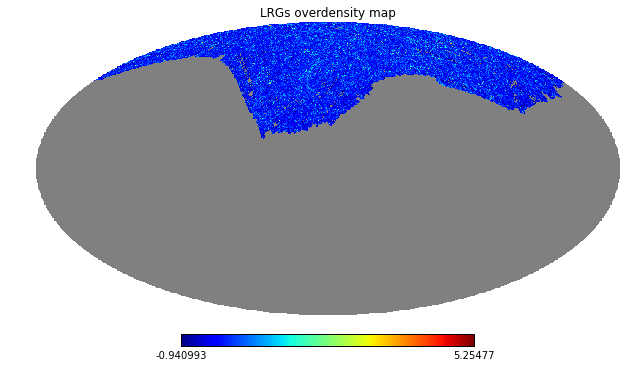

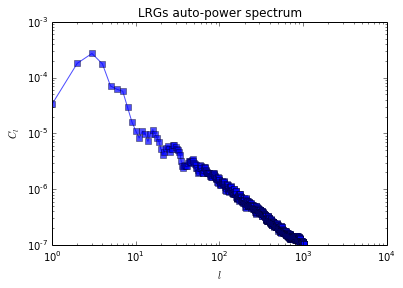

In [7]:
%matplotlib inline
import fitsio
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

#####################################
##            Constants            ##
#####################################
NSIDE = 512
LMAX = 1024
PHI_ROT = 180
ZGT = '070'
PLANEMASKCOVERAGE = 40

#####################################
##           Galaxies              ##
#####################################
theta = np.array([])
phi   = np.array([])

for i in xrange(545): ## 545 fits files in total
    fits = fitsio.FITS(FGAL+str(i).zfill(3)+'.fits')
    theta = np.append(theta, fits[1]['dec'][:])
    phi   = np.append(phi,   fits[1]['ra'][:])
    fits.close()

##===  (ra, dec) -> (theta, phi)
theta = (-1)*theta*np.pi/180. + np.pi/2.
phi = phi*np.pi/180. 

##===  Celestial coordinate -> galactic coordinate
rotation = [PHI_ROT, 0.0] ## (phi, theta) in deg.
r_C2G = hp.Rotator(rot=rotation, coord=['C', 'G'])
theta, phi = r_C2G(theta, phi)

#==============  galaxies --> pixel =================
galMap = np.zeros(hp.nside2npix(NSIDE))
galPix = hp.ang2pix(NSIDE, theta, phi)

for pix in galPix:
    galMap[pix] += 1  ## count map

# hp.mollview(galMap, title="LRGs count map")
# plt.show()    

##============= mask out south  ====================
maskHemi =  np.arange(hp.nside2npix(NSIDE))
npixs = len(maskHemi)
for i in xrange(npixs):
    if (i<= npixs/2):
        maskHemi[i] = True
    else:
        maskHemi[i] = False


##============== DR12 CMASS North mask ==============
if PHI_ROT == 0:
    GALMAPMASK = '/Users/jh/Desktop/data/SDSS/mask_DR12v5_CMASS_North_512_galactic_x4.fits'
else:
    GALMAPMASK = "/Users/jh/Desktop/data/SDSS/mask_DR12v5_CMASS_North_512_galactic_x4_rot%i.fits"%(PHI_ROT)
galmapmask = hp.read_map(GALMAPMASK)
galmapmask = galmapmask > GALMAPMASKTHRESHOLD


##============== apply all the masks ===============
galmask = np.logical_and(maskHemi, galmapmask)
galMapMasked = hp.ma(galMap)
galMapMasked.mask = np.logical_not(galmask)        
        

##============ count --> overdensity ==================
galMap_Ngal = 0
galMap_Npix = 0  ## keep track of the number of pixels covered
for i in xrange(len(galMapMasked)):
    if galMapMasked[i] == 0:
        galMapMasked[i] = hp.UNSEEN
#        galMap_Npix+=1
    if galMapMasked[i] != hp.UNSEEN:
        galMap_Ngal+=galMapMasked[i]
        galMap_Npix+=1
        
countMean = float(galMap_Ngal)/galMap_Npix

for i in xrange(len(galMapMasked)):
    if galMapMasked[i] != hp.UNSEEN:
        galMapMasked[i] = (galMapMasked[i] - countMean)/countMean

hp.mollview(galMapMasked, title='LRGs overdensity map')
plt.show()


#######################################
###   galaxy auto-power spectrum    ###
#######################################
galAlm = hp.map2alm(galMapMasked, lmax=LMAX, pol=False)
galCl  = hp.alm2cl(galAlm)
if PHI_ROT==0:
    hp.write_alm("res/zgt%s_north_N%i.alm"%(ZGT, NSIDE), galAlm)
else:
    hp.write_alm("res/zgt%s_north_N%i_rot%i.alm"%(ZGT, NSIDE, PHI_ROT), galAlm)

cl_plot(galCl, style='s-')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$l$')
plt.ylabel('$C_l$')
plt.ylim([10**-7, 10**-3])
plt.title('LRGs auto-power spectrum')
plt.show()



# Planck Map

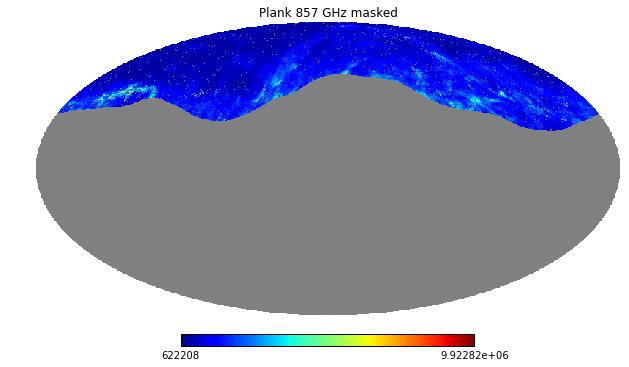

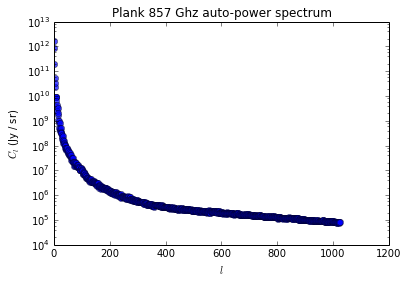

In [99]:
%matplotlib inline
import fitsio
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

#####################################
##            Constants            ##
#####################################
PLANEMASKCOVERAGE = 40
NSIDE_PLANCK = 2048
LMAX = 1024
MAPFREQ = 857

######################################
##           Planck Map             ##
######################################

planckmap = hp.read_map(FMAP[MAPFREQ], verbose=False)*10**6
# hp.mollview(planckmap, title="Plank %i GHz"%(MAPFREQ))
# plt.show()

##====== mask out south, plane and PS ========
maskPS = hp.read_map(FMAPMASKPS, field=PCFIELD[MAPFREQ], verbose=False).astype(bool) ##field=5 for F857
maskPlane = hp.read_map(FMAPMASKPLANE, field=PLANEMASKFIELD[PLANEMASKCOVERAGE], verbose=False).astype(bool) 

maskHemi =  np.arange(hp.nside2npix(NSIDE_PLANCK))
npixs = len(maskHemi)
for i in xrange(npixs):
    if (i<= npixs/2):
        maskHemi[i] = True
    else:
        maskHemi[i] = False

mask = np.logical_and(maskPS, maskPlane)
mask = np.logical_and(mask, maskHemi)
planckmapMasked = hp.ma(planckmap)
planckmapMasked.mask = np.logical_not(mask)

hp.mollview(planckmapMasked,title="Plank %i GHz masked"%(MAPFREQ))
plt.show()


#########################################
###     CIB auto-power spectrum      ####
#########################################
planckAlm = hp.map2alm(planckmapMasked, lmax=LMAX, pol=False)
planckCl  = hp.alm2cl(planckAlm)
hp.write_alm("res/planck%i_cov%i_north.alm"%(MAPFREQ, PLANEMASKCOVERAGE), planckAlm)
cl_plot(planckCl)
plt.xlabel('$l$')
plt.ylabel('$C_l$ (Jy / sr)')
plt.yscale('log')
plt.title('Plank %i Ghz auto-power spectrum'%(MAPFREQ))
plt.show()

# Cross-Correlation

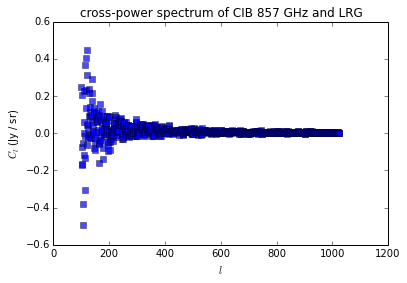

In [9]:
MAPFREQ = 857
COVERAGE=40
NSIDE = 512
LMIN = 100
BINSIZE = 1
ZGT = '070'
####################################
###         LRG vs. 857          ###
####################################
f_galm = "res/zgt%s_north_N%i.alm"%(ZGT, NSIDE)
f_palm = "res/planck%i_cov%i_north.alm"%(MAPFREQ, COVERAGE)
cross_alm(f_galm, f_palm, lmin=LMIN, binSize=BINSIZE)
plt.title('cross-power spectrum of CIB %i GHz and LRG'%(MAPFREQ))
# plt.xscale('log')
plt.show()

### LRG z>0.7 vs. CIB at 857 GHz

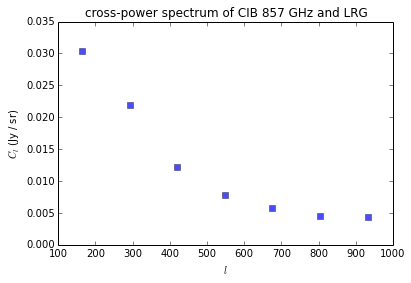

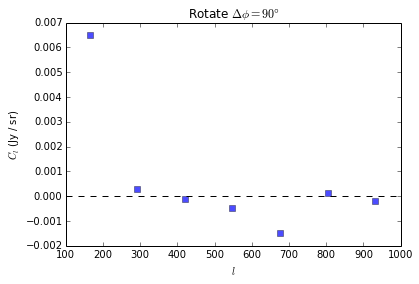

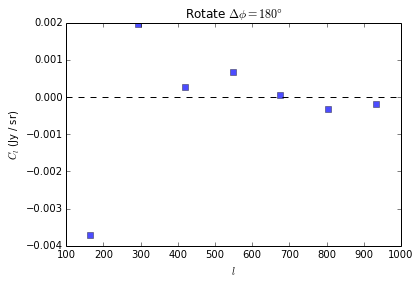

In [7]:
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

MAPFREQ = 857
COVERAGE=40
NSIDE = 512
LMIN = 100
BINSIZE = 128
ZGT = '070'
x = np.linspace(100,1000, 100)
y = x*0.0
####################################
###         LRG vs. 857          ###
####################################
f_galm = "res/zgt%s_north_N%i.alm"%(ZGT, NSIDE)
f_palm = "res/planck%i_cov%i_north.alm"%(MAPFREQ, COVERAGE)
cross_alm(f_galm, f_palm, lmin=LMIN, binSize=BINSIZE)
plt.title('cross-power spectrum of CIB %i GHz and LRG'%(MAPFREQ))
plt.savefig('figure/zgt070_857_N512.eps')
plt.show()

## =========== Rotate 90 =============
f_galm = "res/zgt%s_north_N%i_rot%i.alm"%(ZGT, NSIDE, 90)
f_palm = "res/planck%i_cov%i_north.alm"%(MAPFREQ, COVERAGE)
cross_alm(f_galm, f_palm, lmin=LMIN, binSize=BINSIZE)
plt.title('Rotate $\Delta \phi = 90\degree$')
plt.plot(x, y, 'k--')
plt.savefig('figure/zgt070_857_N512_rot90.eps')
plt.show()

## =========== Rotate 180 ===============
f_galm = "res/zgt%s_north_N%i_rot%i.alm"%(ZGT, NSIDE, 180)
f_palm = "res/planck%i_cov%i_north.alm"%(MAPFREQ, COVERAGE)
cross_alm(f_galm, f_palm, lmin=LMIN, binSize=BINSIZE)
plt.title('Rotate $\Delta \phi = 180\degree$')
plt.plot(x, y, 'k--')
plt.savefig('figure/zgt070_857_N512_rot180.eps')
plt.show()


### LRG z>0.7 vs. CIB at 545 GHz

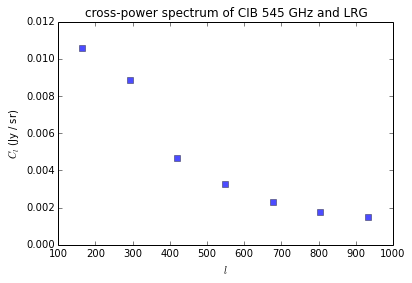

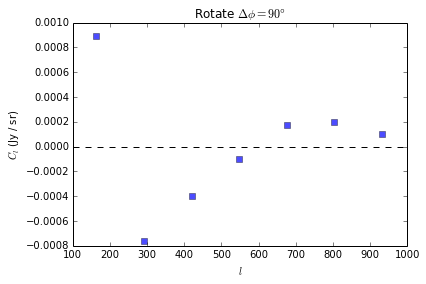

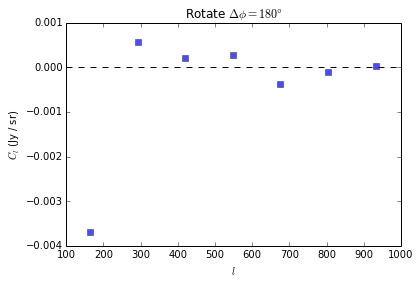

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

MAPFREQ = 545
COVERAGE=40
NSIDE = 512
LMIN = 100
BINSIZE = 128
ZGT = '070'
x = np.linspace(100,1000, 100)
y = x*0.0
####################################
###         LRG vs. 545          ###
####################################
f_galm = "res/zgt%s_north_N%i.alm"%(ZGT, NSIDE)
f_palm = "res/planck%i_cov%i_north.alm"%(MAPFREQ, COVERAGE)
cross_alm(f_galm, f_palm, lmin=LMIN, binSize=BINSIZE)
plt.title('cross-power spectrum of CIB %i GHz and LRG'%(MAPFREQ))
plt.savefig('figure/zgt070_545_N512.eps')
plt.show()

## =========== Rotate 90 =============
f_galm = "res/zgt%s_north_N%i_rot%i.alm"%(ZGT, NSIDE, 90)
f_palm = "res/planck%i_cov%i_north.alm"%(MAPFREQ, COVERAGE)
cross_alm(f_galm, f_palm, lmin=LMIN, binSize=BINSIZE)
plt.title('Rotate $\Delta \phi = 90\degree$')
plt.plot(x, y, 'k--')
plt.savefig('figure/zgt070_545_N512_rot90.eps')
plt.show()

## =========== Rotate 180 ===============
f_galm = "res/zgt%s_north_N%i_rot%i.alm"%(ZGT, NSIDE, 180)
f_palm = "res/planck%i_cov%i_north.alm"%(MAPFREQ, COVERAGE)
cross_alm(f_galm, f_palm, lmin=LMIN, binSize=BINSIZE)
plt.title('Rotate $\Delta \phi = 180\degree$')
plt.plot(x, y, 'k--')
plt.savefig('figure/zgt070_545_N512_rot180.eps')
plt.show()



## u-g Bins

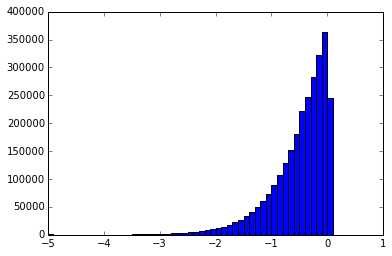

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


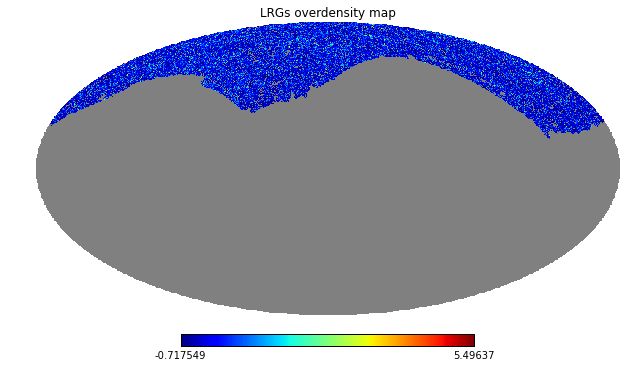

        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead. [astropy.utils.decorators]
        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead.


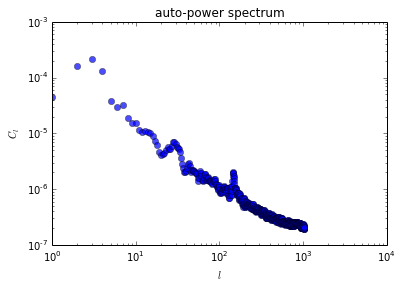

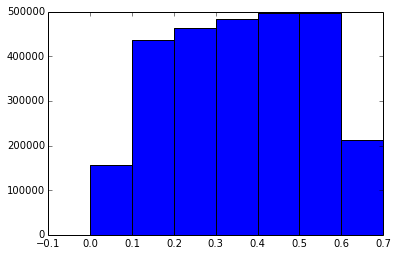

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


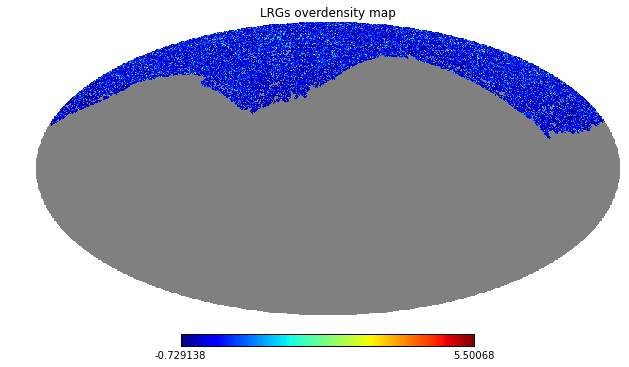

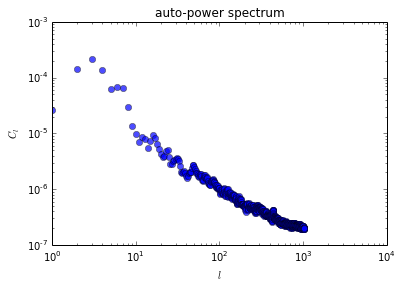

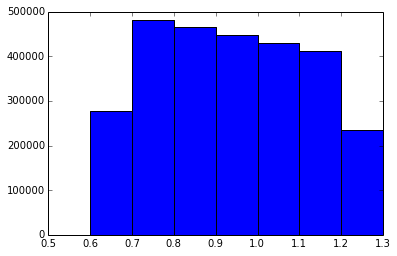

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


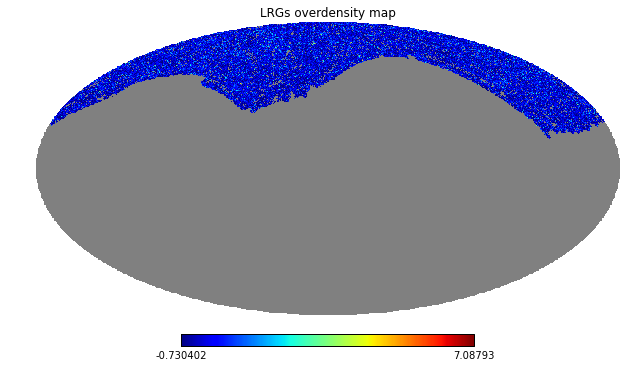

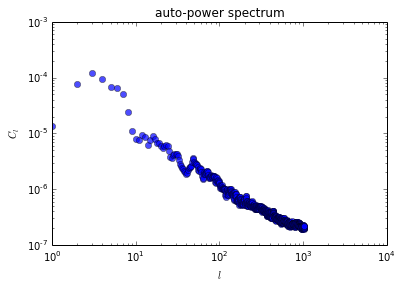

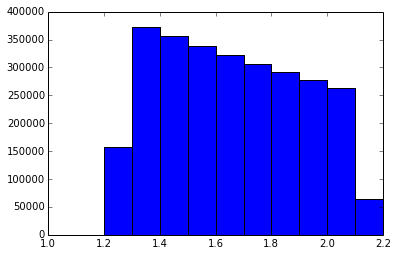

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


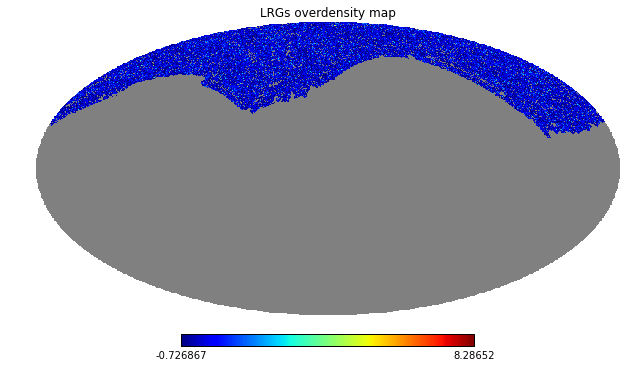

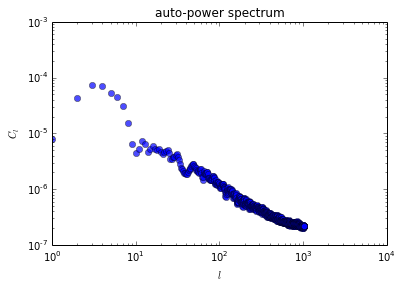

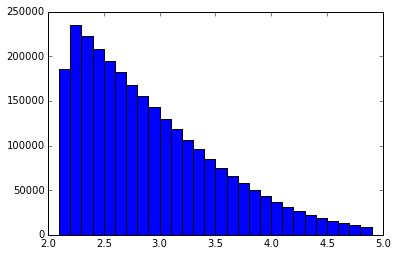

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


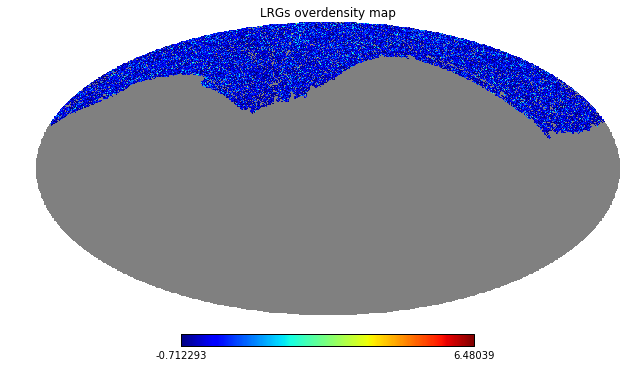

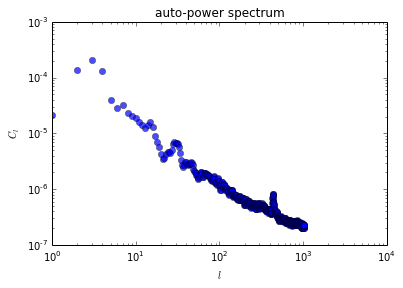

In [9]:
##### calculate LRG alm based on different color bins ######

% matplotlib inline
import fitsio
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

ZGT = '070'
NSIDE = 512
UBBins = 5
LMAX = 1024

UBarrLs= np.array([])
thetaLs = np.array([])
phiLs = np.array([])

for i in xrange(545): ## 545 fits files in total
    fits = fitsio.FITS(FGAL+str(i).zfill(3)+'.fits')
    UBarrLs = np.append(UBarrLs, fits[1]['modelmag'][:][:,0]-fits[1]['modelmag'][:][:,1])
    thetaLs = np.append(thetaLs, fits[1]['dec'][:])
    phiLs   = np.append(phiLs,   fits[1]['ra'][:])
    fits.close()


for UBBinIndex in xrange(1, UBBins+1):
    
    select = np.where(np.abs(UBarrLs)<10)
    UBarr = UBarrLs[select] ##discard extreme values
    theta = thetaLs[select]
    phi   = phiLs[select]
    lenTot = len(UBarr)


    order = UBarr.argsort()
    UBarr = UBarr[order][(UBBinIndex-1)*lenTot/UBBins: UBBinIndex*lenTot/UBBins]
    theta = theta[order][(UBBinIndex-1)*lenTot/UBBins: UBBinIndex*lenTot/UBBins]
    phi   = phi[order][(UBBinIndex-1)*lenTot/UBBins: UBBinIndex*lenTot/UBBins]


    plt.hist(UBarr, bins=np.arange(-5, 5, 0.1))
    plt.show()

    ##===  (ra, dec) -> (theta, phi)
    theta = (-1)*theta*np.pi/180. + np.pi/2.
    phi = phi*np.pi/180. 

    ##===  Celestial coordinate -> galactic coordinate
    rotation = [0.0, 0.0] ## (phi, theta) in deg.
    r_C2G = hp.Rotator(rot=rotation, coord=['C', 'G'])
    theta, phi = r_C2G(theta, phi)

    #==============  galaxies --> pixel =================
    galMap = np.zeros(hp.nside2npix(NSIDE))
    galPix = hp.ang2pix(NSIDE, theta, phi)

    for pix in galPix:
        galMap[pix] += 1  ## count map



    ##============= mask out south  ====================
    maskHemi =  np.arange(hp.nside2npix(NSIDE))
    npixs = len(maskHemi)
    for i in xrange(npixs):
        if (i<= npixs/2):
            maskHemi[i] = True
        else:
            maskHemi[i] = False


    ##============== DR12 CMASS North mask ==============

    GALMAPMASK = '/Users/jh/Desktop/data/SDSS/mask_DR12v5_CMASS_North_512_galactic_x4.fits'
    galmapmask = hp.read_map(GALMAPMASK)
    galmapmask = galmapmask > GALMAPMASKTHRESHOLD


    ##============== apply all the masks ===============
    galmask = np.logical_and(maskHemi, galmapmask)
    galMapMasked = hp.ma(galMap)
    galMapMasked.mask = np.logical_not(galmask)     





    ##============ count --> overdensity ==================
    galMap_Ngal = 0
    galMap_Npix = 0  ## keep track of the number of pixels covered
    for i in xrange(len(galMapMasked)):
        if galMapMasked[i] == 0:
            galMapMasked[i] = hp.UNSEEN
        if galMapMasked[i] != hp.UNSEEN:
            galMap_Ngal+=galMapMasked[i]
            galMap_Npix+=1

    countMean = float(galMap_Ngal)/galMap_Npix

    for i in xrange(len(galMapMasked)):
        if galMapMasked[i] != hp.UNSEEN:
            galMapMasked[i] = (galMapMasked[i] - countMean)/countMean

    hp.mollview(galMapMasked, title='LRGs overdensity map')
    plt.show()

    #######################################
    ###   galaxy auto-power spectrum    ###
    #######################################
    galAlm = hp.map2alm(galMapMasked, lmax=LMAX, pol=False)
    galCl  = hp.alm2cl(galAlm)

    hp.write_alm("res/zgt%s_north_N%i_UB%i-%i.alm"%(ZGT, NSIDE, UBBinIndex, UBBins), galAlm)


    cl_plot(galCl)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$l$')
    plt.ylabel('$C_l$')
    plt.ylim([10**-7, 10**-3])
    plt.title('auto-power spectrum')
    plt.show()




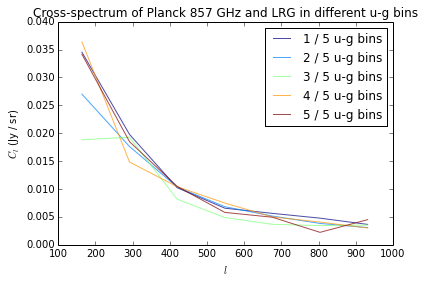

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

MAPFREQ = 857
COVERAGE=40
NSIDE = 512
LMIN = 100
BINSIZE = 128
ZGT = '070'
UBBins = 5
####################################
###         LRG vs. 857          ###
####################################
# f_galm = "res/zgt%s_north_N%i.alm"%(ZGT, NSIDE)
# f_galm_UB13 = "res/zgt%s_north_N%i_UB13.alm"%(ZGT, NSIDE)
# f_galm_UB23 = "res/zgt%s_north_N%i_UB23.alm"%(ZGT, NSIDE)
# f_galm_UB33 = "res/zgt%s_north_N%i_UB33.alm"%(ZGT, NSIDE)
# f_palm = "res/planck%i_cov%i_north.alm"%(MAPFREQ, COVERAGE)
# a, plotT = cross_alm(f_galm, f_palm, lmin=LMIN, binSize=BINSIZE, style='b-')
# a, plot1 = cross_alm(f_galm_UB13, f_palm, lmin=LMIN, binSize=BINSIZE, style='rs')
# a, plot2 = cross_alm(f_galm_UB23, f_palm, lmin=LMIN, binSize=BINSIZE, style='g+')
# a, plot3 = cross_alm(f_galm_UB33, f_palm, lmin=LMIN, binSize=BINSIZE, style='c^')
# plt.title('cross-power spectrum of CIB %i GHz and LRG'%(MAPFREQ))
# plt.legend([plotT, plot1, plot2, plot3], ['all', '1/3', '2/3', '3/3'])
# plt.show()

f_galm = "res/zgt%s_north_N%i.alm"%(ZGT, NSIDE)
f_palm = "res/planck%i_cov%i_north.alm"%(MAPFREQ, COVERAGE)

f_galm_UB=["res/zgt%s_north_N%i_UB%i-%i.alm"%(ZGT, NSIDE, i, UBBins) for i in xrange(1, UBBins+1)]

cmap = plt.get_cmap('jet')
line_colors = cmap(np.linspace(0,1,UBBins))
# cross_alm(f_galm, f_palm, lmin=LMIN, binSize=BINSIZE, style='s', c=line_colors[0], label='total')
for i in xrange(0, UBBins):
    cross_alm(f_galm_UB[i], f_palm, lmin=LMIN, binSize=BINSIZE, style='-', c=line_colors[i], label='%i / %i u-g bins'%(i+1, UBBins))
plt.legend()
plt.title('Cross-spectrum of Planck %i GHz and LRG in different u-g bins'%(MAPFREQ))
plt.show()

In [4]:
################################################################################
#####This block converts the mask map in celestial coord to galactic coord######
################################################################################

#galmapmask = hp.read_map('/Users/jh/Desktop/data/SDSS/mask_DR10v8_CMASS_North_512.fits')

print "reading fits map..."
galmapmask = hp.read_map('/Users/jh/Desktop/data/SDSS/mask_DR12v5_CMASS_North_512.fits')
print "map read!"

npix = hp.nside2npix(NSIDE)
PHI_ROT = 0
rotation = [PHI_ROT, 0.0] ## (phi, theta) in deg.
r_C2G = hp.Rotator(rot=rotation, coord=['C', 'G'])
ngrid = 4*np.floor(np.sqrt(npix))  ## 16 times grid pts
theta = np.linspace(0, np.pi, ngrid)
phi = np.linspace(0, 2*np.pi, ngrid)
galmapmask_rot = np.zeros(npix)    

print "iteration starts"
for t in theta:
    for p in phi:
        trot, prot = r_C2G(t, p)
        i = hp.ang2pix(NSIDE, t, p)
        j = hp.ang2pix(NSIDE, trot, prot)
        galmapmask_rot[j] = galmapmask[i]

hp.mollview(galmapmask_rot)

if PHI_ROT ==0:
    hp.write_map('/Users/jh/Desktop/data/SDSS/mask_DR12v5_CMASS_North_512_galactic_x4.fits', galmapmask_rot, coord='G')
else: 
    hp.write_map("/Users/jh/Desktop/data/SDSS/mask_DR12v5_CMASS_North_512_galactic_x4_rot%i.fits"%(PHI_ROT), galmapmask_rot, coord='G')


reading fits map...


IOError: [Errno 2] No such file or directory: '/Users/jh/Desktop/data/SDSS/mask_DR12v5_CMASS_North_512.fits'

No. 0
No. 1
No. 2
No. 3
No. 4
No. 5
No. 6
No. 7
No. 10
No. 11
No. 12
No. 13
No. 14
No. 15
No. 16
No. 17
No. 19
No. 20
No. 21
No. 22
No. 23
No. 26
No. 27
No. 29
No. 30
No. 31
No. 51
No. 54
No. 55
29


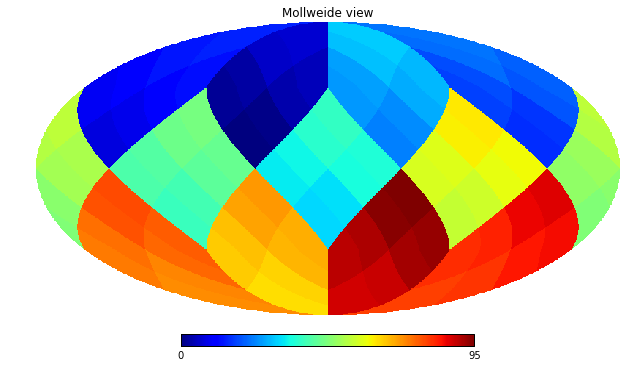

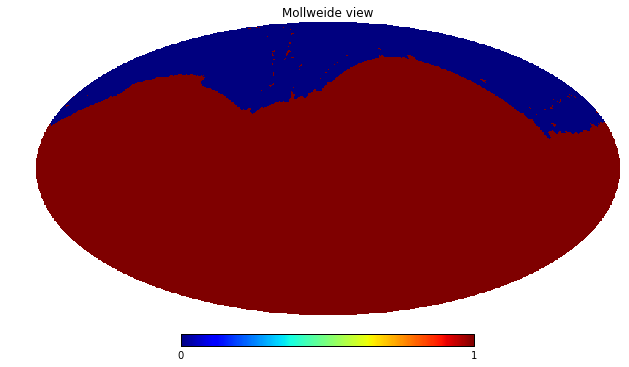

In [80]:
nside = 512
npix = hp.nside2npix(nside)
m = np.zeros(npix)
npix = 12 * nside**2
ngroup = 12*8

for i in xrange(npix):
    m[i] = i/(npix/ngroup)

hp.mollview(m, nest=True)
hp.mollview(mask_stored, nest=True)
n_overlap = 0
for i in xrange(ngroup):
    tmp = np.logical_and(m==i, np.logical_not(mask_stored))
    if np.any(tmp):
        print "No. %i"%(i)
#         hp.mollview(tmp, nest=True)
        n_overlap= n_overlap+1
#         plt.show()

print n_overlap

## Jack-Knife


NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


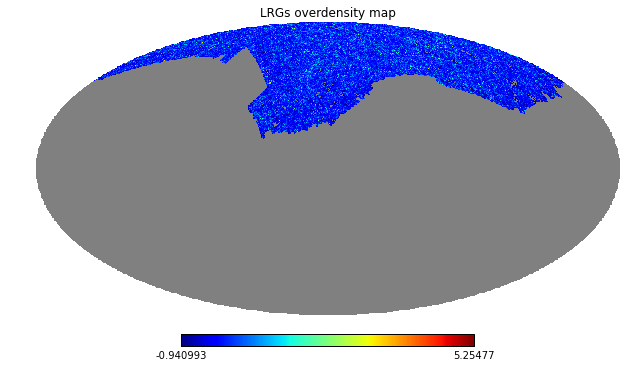

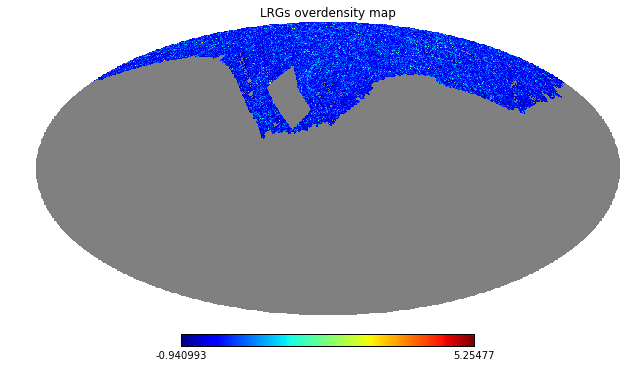

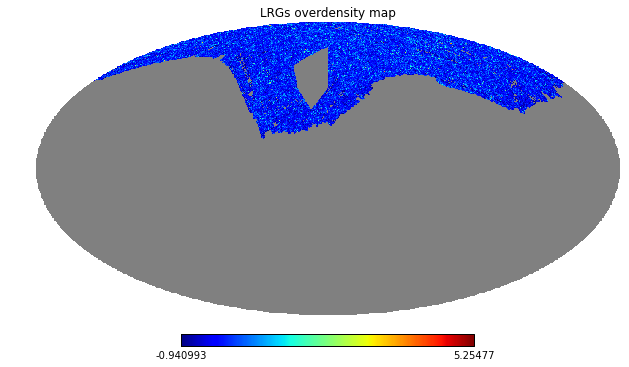

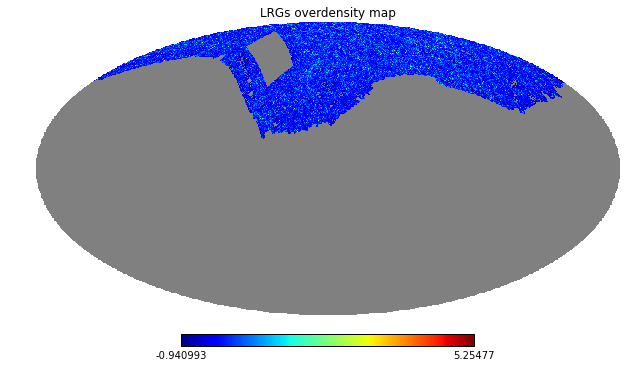

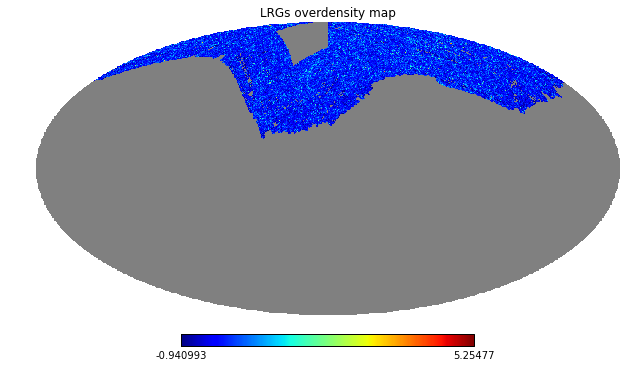

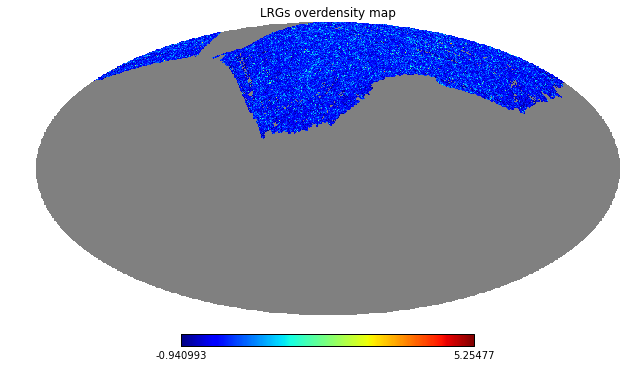

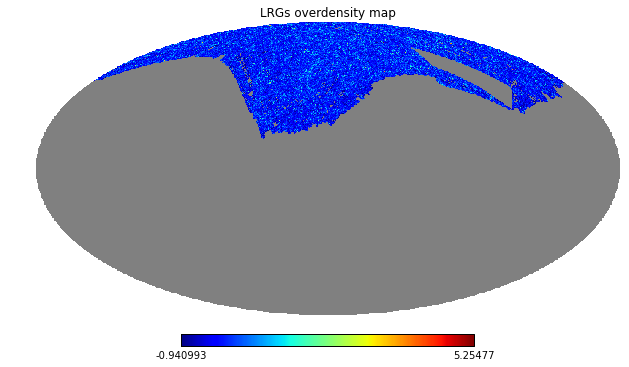

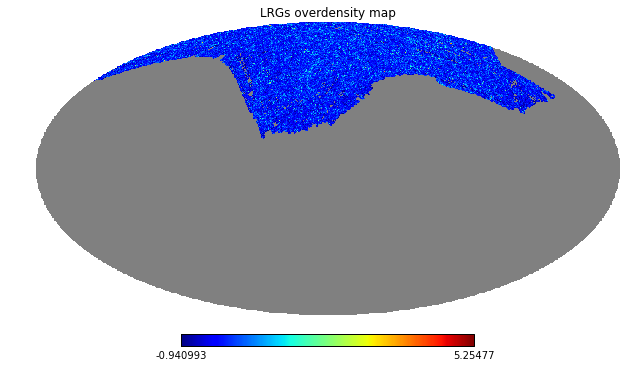

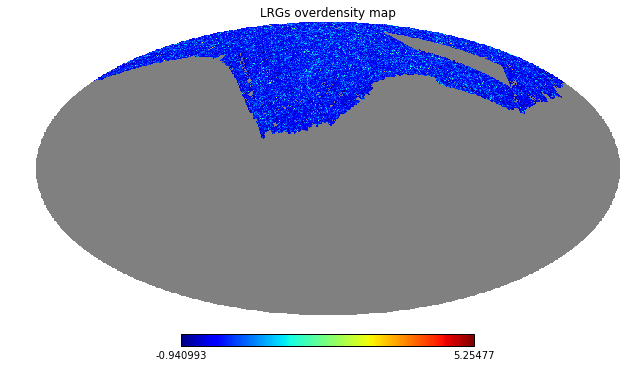

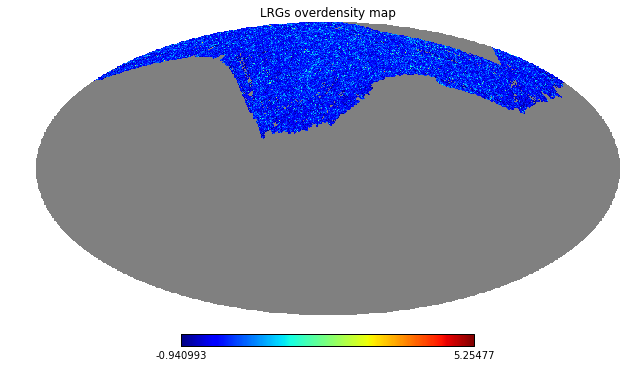

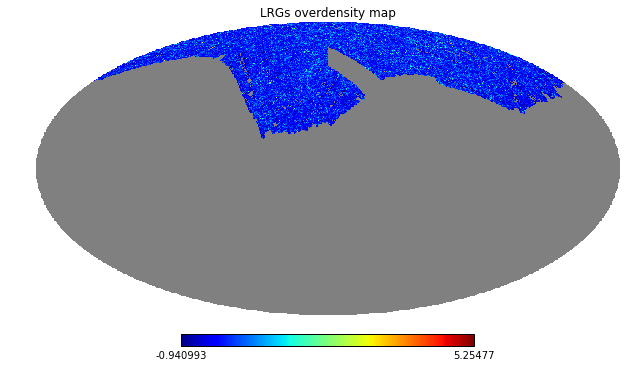

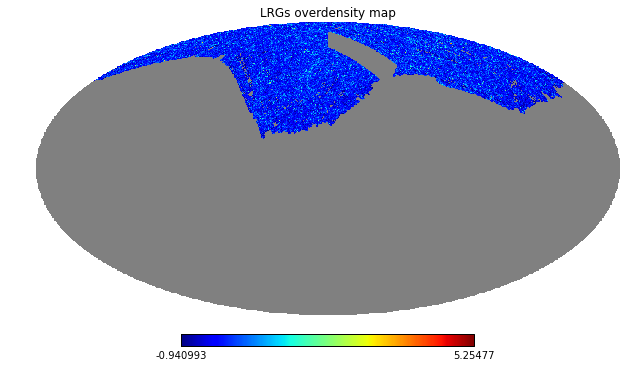

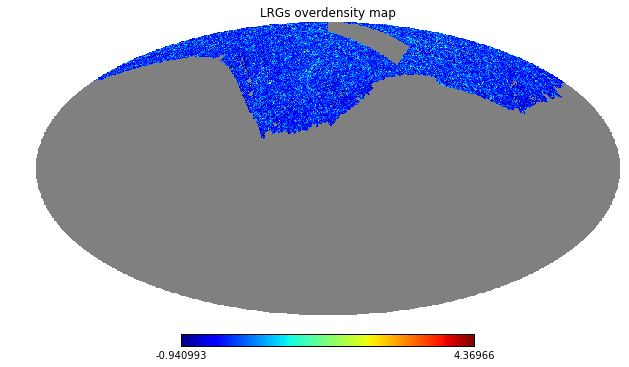

In [189]:
%matplotlib inline
import fitsio
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

#####################################
##            Constants            ##
#####################################
NSIDE = 512
LMAX = 1024
PHI_ROT = 180
ZGT = '070'
PLANEMASKCOVERAGE = 40
isNest = False
ngroup = 12*8
jkOverlapThreshold = 0.75
#####################################
##           Galaxies              ##
#####################################
theta = np.array([])
phi   = np.array([])

for i in xrange(545): ## 545 fits files in total
    fits = fitsio.FITS(FGAL+str(i).zfill(3)+'.fits')
    theta = np.append(theta, fits[1]['dec'][:])
    phi   = np.append(phi,   fits[1]['ra'][:])
    fits.close()

##===  (ra, dec) -> (theta, phi)
theta = (-1)*theta*np.pi/180. + np.pi/2.
phi = phi*np.pi/180. 

##===  Celestial coordinate -> galactic coordinate
rotation = [PHI_ROT, 0.0] ## (phi, theta) in deg.
r_C2G = hp.Rotator(rot=rotation, coord=['C', 'G'])
theta, phi = r_C2G(theta, phi)

#==============  galaxies --> pixel =================
galMap = np.zeros(hp.nside2npix(NSIDE))
galPix = hp.ang2pix(NSIDE, theta, phi, nest=isNest)

for pix in galPix:
    galMap[pix] += 1  ## count map

# hp.mollview(galMap, title="LRGs count map")
# plt.show()    

##============= mask out south  ====================
maskHemi =  np.arange(hp.nside2npix(NSIDE))
npixs = len(maskHemi)
for i in xrange(npixs):
    if (i<= npixs/2):
        maskHemi[i] = True
    else:
        maskHemi[i] = False
if isNest:
    maskHemi = hp.reorder(maskHemi, r2n=True)

##============== DR12 CMASS North mask ==============
if PHI_ROT == 0:
    GALMAPMASK = '/Users/jh/Desktop/data/SDSS/mask_DR12v5_CMASS_North_512_galactic_x4.fits'
else:
    GALMAPMASK = "/Users/jh/Desktop/data/SDSS/mask_DR12v5_CMASS_North_512_galactic_x4_rot%i.fits"%(PHI_ROT)
galmapmask = hp.read_map(GALMAPMASK, nest=isNest)
galmapmask = galmapmask > GALMAPMASKTHRESHOLD


##============== apply all the masks ===============
galmask = np.logical_and(maskHemi, galmapmask)
galMapMasked = hp.ma(galMap)
galMapMasked.mask = np.logical_not(galmask)        
        

##============ count --> overdensity ==================
galMap_Ngal = 0
galMap_Npix = 0  ## keep track of the number of pixels covered
for i in xrange(len(galMapMasked)):
    if galMapMasked[i] == 0:
        galMapMasked[i] = hp.UNSEEN

    if galMapMasked[i] != hp.UNSEEN:
        galMap_Ngal+=galMapMasked[i]
        galMap_Npix+=1

countMean = float(galMap_Ngal)/galMap_Npix

for i in xrange(len(galMapMasked)):
    if galMapMasked[i] != hp.UNSEEN:
        galMapMasked[i] = (galMapMasked[i] - countMean)/countMean


    
#######################################################
##############  Apply jack knife mask #################
#######################################################
NPIX = hp.nside2npix(NSIDE)
jmask = np.zeros(NPIX)


mask_stored = np.copy(galMapMasked.mask)

for i in xrange(NPIX):
    jmask[i] = i/(NPIX/ngroup)
    
if not isNest:
    jmask = hp.reorder(jmask, n2r=True)

npix_jmask = len(np.where(jmask==0)[0])
for ji in xrange(ngroup):
    tmp = np.logical_and(jmask==ji, np.logical_not(mask_stored))
    npix_overlap = len(np.where(tmp)[0])
    if npix_overlap > npix_jmask * jkOverlapThreshold:
        galMapMasked.mask = np.logical_or(jmask==ji, mask_stored)
        hp.mollview(galMapMasked, title='LRGs overdensity map', nest=isNest)
        plt.show()


#######################################
###   galaxy auto-power spectrum    ###
#######################################
        galAlm = hp.map2alm(galMapMasked, lmax=LMAX, pol=False)

        if PHI_ROT==0:
            hp.write_alm("res/zgt%s_north_N%i_%i-%i_thre0%i.alm"%(ZGT, NSIDE, ji, ngroup, int(jkOverlapThreshold*100)), galAlm)
        else:
            hp.write_alm("res/zgt%s_north_N%i_%i-%i_thre0%i_rot%i.alm"%(ZGT, NSIDE, ji, ngroup,int(jkOverlapThreshold*100), PHI_ROT), galAlm)

#         galCl  = hp.alm2cl(galAlm)
#         cl_plot(galCl, style='s-')
#         plt.yscale('log')
#         plt.xscale('log')
#         plt.xlabel('$l$')
#         plt.ylabel('$C_l$')
#         plt.ylim([10**-7, 10**-3])
#         plt.title('LRGs auto-power spectrum')
#         plt.show()



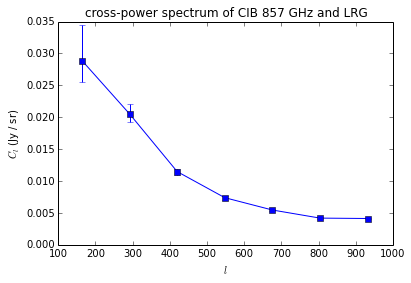

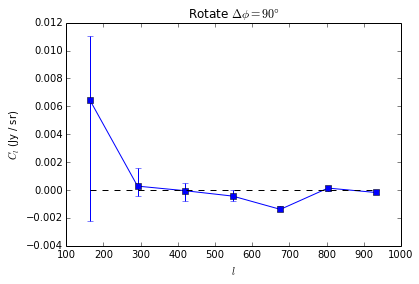

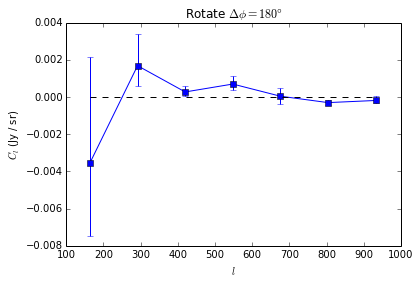

In [24]:
######## Show the error bars in CL, freq=857 ############

import os

MAPFREQ = 857
COVERAGE=40
NSIDE = 512
LMIN = 100
BINSIZE = 128
ZGT = '070'
jkOverlapThreshold = 0.75
x = np.linspace(100,1000, 100)
y = x*0.0
ngroup = 12 * 8
for ROTNAME in  ["", "_rot90", "_rot180"]:
    clLs=np.array([])
    for i in xrange(ngroup):
        if os.path.exists("res/zgt%s_north_N%i_%i-%i_thre0%i%s.alm"%(ZGT, NSIDE, i, ngroup, int(jkOverlapThreshold*100),ROTNAME)):
            f_galm = "res/zgt%s_north_N%i_%i-%i_thre0%i%s.alm"%(ZGT, NSIDE, i, ngroup, int(jkOverlapThreshold*100),ROTNAME)
    #         f_galm = "res/zgt%s_north_N%i.alm"%(ZGT, NSIDE)
        else:
            continue
        f_palm = "res/planck%i_cov%i_north.alm"%(MAPFREQ, COVERAGE)
        cl_cross = cross_alm(f_galm, f_palm, lmin=LMIN, binSize=BINSIZE, doPlot=False)
        ell = np.arange(len(cl_cross))
        ell_bin, cl_bin = cl_binned(ell[LMIN:], cl_cross[LMIN:], BINSIZE)
        if len(clLs)==0:
            clLs = np.copy(cl_bin)
        else:
            clLs = np.vstack((clLs, cl_bin))



    clMean =  np.mean(clLs, axis=0)
    clMax = np.max(clLs, axis=0)
    clMin = np.min(clLs, axis=0)
    clStd = np.std(clLs, axis=0)



    plt.errorbar(ell_bin, clMean, yerr=[clMean-clMin, clMax-clMean], fmt='bs-')
    plt.plot(ell_bin, np.zeros(len(ell_bin)), 'k--')
    plt.xlabel('$l$')
    plt.ylabel('$C_l$ (Jy / sr)')
    if ROTNAME == "":
        plt.title('cross-power spectrum of CIB %i GHz and LRG'%(MAPFREQ))
    elif ROTNAME == "_rot90":
        plt.title('Rotate $\Delta \phi = 90\degree$')
    else:
        plt.title('Rotate $\Delta \phi = 180\degree$')
    plt.savefig("figure/zgt%s_%i_N%i_jk%i%s.eps"%(ZGT, MAPFREQ, NSIDE, ngroup,ROTNAME))
    plt.show()

#     plt.plot(ell_bin, clMean, 'bs', alpha=0.7)
#     plt.plot(ell_bin, np.zeros(len(ell_bin)), 'k--')
#     plt.errorbar(ell_bin, clMean, yerr=2*clStd)
#     plt.show()

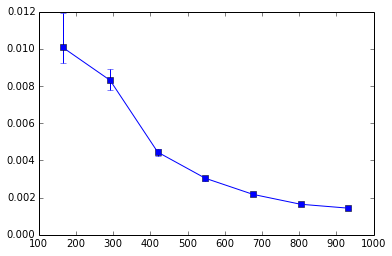

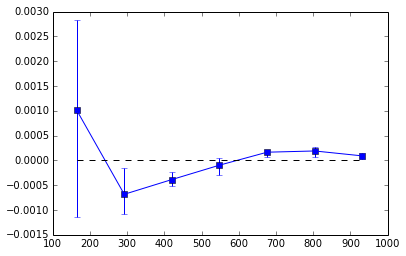

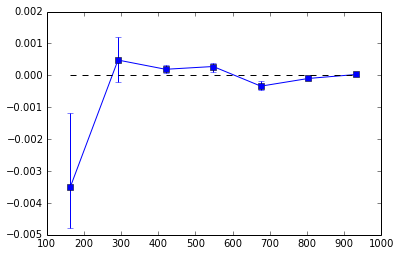

In [32]:
######## Show the error bars in CL, freq=545 ############

import os

MAPFREQ = 545
COVERAGE=40
NSIDE = 512
LMIN = 100
BINSIZE = 128
ZGT = '070'
jkOverlapThreshold = 0.75
x = np.linspace(100,1000, 100)
y = x*0.0
ngroup = 12 * 8
for ROTNAME in  ["", "_rot90", "_rot180"]:
    clLs=np.array([])
    for i in xrange(ngroup):
        if os.path.exists("res/zgt%s_north_N%i_%i-%i_thre0%i%s.alm"%(ZGT, NSIDE, i, ngroup, int(jkOverlapThreshold*100),ROTNAME)):
            f_galm = "res/zgt%s_north_N%i_%i-%i_thre0%i%s.alm"%(ZGT, NSIDE, i, ngroup, int(jkOverlapThreshold*100),ROTNAME)
    #         f_galm = "res/zgt%s_north_N%i.alm"%(ZGT, NSIDE)
        else:
            continue
        f_palm = "res/planck%i_cov%i_north.alm"%(MAPFREQ, COVERAGE)
        cl_cross = cross_alm(f_galm, f_palm, lmin=LMIN, binSize=BINSIZE, doPlot=False)
        ell = np.arange(len(cl_cross))
        ell_bin, cl_bin = cl_binned(ell[LMIN:], cl_cross[LMIN:], BINSIZE)
        if len(clLs)==0:
            clLs = np.copy(cl_bin)
        else:
            clLs = np.vstack((clLs, cl_bin))



    clMean =  np.mean(clLs, axis=0)
    clMax = np.max(clLs, axis=0)
    clMin = np.min(clLs, axis=0)
    clStd = np.std(clLs, axis=0)


    plt.plot(ell_bin, clMean, 'bs')
    plt.errorbar(ell_bin, clMean, yerr=[clMean-clMin, clMax-clMean])
    plt.plot(ell_bin, np.zeros(len(ell_bin)), 'k--')
    plt.show()



In [23]:
##### u-g bins + jack-knife ######

% matplotlib inline
import fitsio
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

ZGT = '070'
NSIDE = 512
UBBins = 10
LMAX = 1024
ngroup = 12*8
jkOverlapThreshold = 0.75

UBarrLs= np.array([])
thetaLs = np.array([])
phiLs = np.array([])

for i in xrange(545): ## 545 fits files in total
    fits = fitsio.FITS(FGAL+str(i).zfill(3)+'.fits')
    UBarrLs = np.append(UBarrLs, fits[1]['modelmag'][:][:,0]-fits[1]['modelmag'][:][:,1])
    thetaLs = np.append(thetaLs, fits[1]['dec'][:])
    phiLs   = np.append(phiLs,   fits[1]['ra'][:])
    fits.close()


for UBBinIndex in xrange(1, UBBins+1):
    
    select = np.where(np.abs(UBarrLs)<10)
    UBarr = UBarrLs[select] ##discard extreme values
    theta = thetaLs[select]
    phi   = phiLs[select]
    lenTot = len(UBarr)


    order = UBarr.argsort()
    UBarr = UBarr[order][(UBBinIndex-1)*lenTot/UBBins: UBBinIndex*lenTot/UBBins]
    theta = theta[order][(UBBinIndex-1)*lenTot/UBBins: UBBinIndex*lenTot/UBBins]
    phi   = phi[order][(UBBinIndex-1)*lenTot/UBBins: UBBinIndex*lenTot/UBBins]


#     plt.hist(UBarr, bins=np.arange(-5, 5, 0.1))
#     plt.show()

    ##===  (ra, dec) -> (theta, phi)
    theta = (-1)*theta*np.pi/180. + np.pi/2.
    phi = phi*np.pi/180. 

    ##===  Celestial coordinate -> galactic coordinate
    rotation = [0.0, 0.0] ## (phi, theta) in deg.
    r_C2G = hp.Rotator(rot=rotation, coord=['C', 'G'])
    theta, phi = r_C2G(theta, phi)

    #==============  galaxies --> pixel =================
    galMap = np.zeros(hp.nside2npix(NSIDE))
    galPix = hp.ang2pix(NSIDE, theta, phi)

    for pix in galPix:
        galMap[pix] += 1  ## count map



    ##============= mask out south  ====================
    maskHemi =  np.arange(hp.nside2npix(NSIDE))
    npixs = len(maskHemi)
    for i in xrange(npixs):
        if (i<= npixs/2):
            maskHemi[i] = True
        else:
            maskHemi[i] = False


    ##============== DR12 CMASS North mask ==============

    GALMAPMASK = '/Users/jh/Desktop/data/SDSS/mask_DR12v5_CMASS_North_512_galactic_x4.fits'
    galmapmask = hp.read_map(GALMAPMASK)
    galmapmask = galmapmask > GALMAPMASKTHRESHOLD


    ##============== apply all the masks ===============
    galmask = np.logical_and(maskHemi, galmapmask)
    galMapMasked = hp.ma(galMap)
    galMapMasked.mask = np.logical_not(galmask)     





    ##============ count --> overdensity ==================
    galMap_Ngal = 0
    galMap_Npix = 0  ## keep track of the number of pixels covered
    for i in xrange(len(galMapMasked)):
        if galMapMasked[i] == 0:
            galMapMasked[i] = hp.UNSEEN
        if galMapMasked[i] != hp.UNSEEN:
            galMap_Ngal+=galMapMasked[i]
            galMap_Npix+=1

    countMean = float(galMap_Ngal)/galMap_Npix

    for i in xrange(len(galMapMasked)):
        if galMapMasked[i] != hp.UNSEEN:
            galMapMasked[i] = (galMapMasked[i] - countMean)/countMean

#     hp.mollview(galMapMasked, title='LRGs overdensity map')
#     plt.show()

    
    #######################################################
    ##############  Apply jack knife mask #################
    #######################################################
    NPIX = hp.nside2npix(NSIDE)
    jmask = np.zeros(NPIX)


    mask_stored = np.copy(galMapMasked.mask)

    for i in xrange(NPIX):
        jmask[i] = i/(NPIX/ngroup)

    jmask = hp.reorder(jmask, n2r=True)

    npix_jmask = len(np.where(jmask==0)[0])
    for ji in xrange(ngroup):
        tmp = np.logical_and(jmask==ji, np.logical_not(mask_stored))
        npix_overlap = len(np.where(tmp)[0])
        if npix_overlap > npix_jmask * jkOverlapThreshold:
            galMapMasked.mask = np.logical_or(jmask==ji, mask_stored)
#             hp.mollview(galMapMasked, title='LRGs overdensity map', nest=isNest)
#             plt.show()
    
    
    
            #######################################
            ###   galaxy auto-power spectrum    ###
            #######################################
            galAlm = hp.map2alm(galMapMasked, lmax=LMAX, pol=False)
            hp.write_alm("res/zgt%s_north_N%i_UB%i-%i_%i-%i_thre0%i.alm"%(ZGT, NSIDE, UBBinIndex, UBBins, ji, ngroup, int(jkOverlapThreshold*100)), galAlm)



#             cl_plot(galCl)
#             plt.yscale('log')
#             plt.xscale('log')
#             plt.xlabel('$l$')
#             plt.ylabel('$C_l$')
#             plt.ylim([10**-7, 10**-3])
#             plt.title('auto-power spectrum')
#             plt.show()





NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


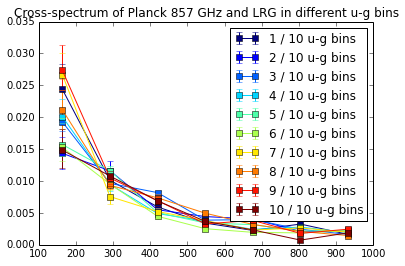

In [8]:
######## Show the error bars of color bins ############

import os

MAPFREQ = 857
COVERAGE=40
NSIDE = 512
LMIN = 100
BINSIZE = 128
ZGT = '070'
jkOverlapThreshold = 0.75
x = np.linspace(100,1000, 100)
y = x*0.0
ngroup = 12 * 8
UBBins = 10

cmap = plt.get_cmap('jet')
line_colors = cmap(np.linspace(0,1,UBBins))

for ci in xrange(1, UBBins+1):
    clLs=np.array([])
    for i in xrange(ngroup):
        if os.path.exists("res/zgt%s_north_N%i_UB%i-%i_%i-%i_thre0%i.alm"%(ZGT, NSIDE, ci, UBBins, i, ngroup, int(jkOverlapThreshold*100))):
            f_galm = "res/zgt%s_north_N%i_UB%i-%i_%i-%i_thre0%i.alm"%(ZGT, NSIDE, ci, UBBins, i, ngroup, int(jkOverlapThreshold*100))

        else:
            continue
        f_palm = "res/planck%i_cov%i_north.alm"%(MAPFREQ, COVERAGE)
        cl_cross = cross_alm(f_galm, f_palm, lmin=LMIN, binSize=BINSIZE, doPlot=False)
        ell = np.arange(len(cl_cross))
        ell_bin, cl_bin = cl_binned(ell[LMIN:], cl_cross[LMIN:], BINSIZE)
        if len(clLs)==0:
            clLs = np.copy(cl_bin)
        else:
            clLs = np.vstack((clLs, cl_bin))



    clMean = np.mean(clLs, axis=0)
    clMax = np.max(clLs, axis=0)
    clMin = np.min(clLs, axis=0)
    clStd = np.std(clLs, axis=0)



    plt.errorbar(ell_bin, clMean, yerr=[clMean-clMin, clMax-clMean], c=line_colors[ci-1], fmt='s-', label='%i / %i u-g bins'%(ci, UBBins))
###### lowest ell only ######
#     plt.errorbar(ci, clMean[0], yerr=[ [(clMean-clMin)[0]], [(clMax-clMean)[0]]], c=line_colors[ci-1], fmt='s')


    
plt.legend()
plt.title('Cross-spectrum of Planck %i GHz and LRG in different u-g bins'%(MAPFREQ))    
plt.show()





## TODO:

1. unit: Mjy                                      DONE
2. phi=0 position of Celestial Coordinate         Checked
3. try CMASS north mask
4. gaussian beam

[Healpy link](http://healpy.readthedocs.org/en/latest/tutorial.html)

---
1. eliminate the "holes" in LRG maps
2. combine the masks: CMASS, north, planck (different NSIDE! Try Nside=1024)
3. deconvolve the mask from the cross-power spectrum

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


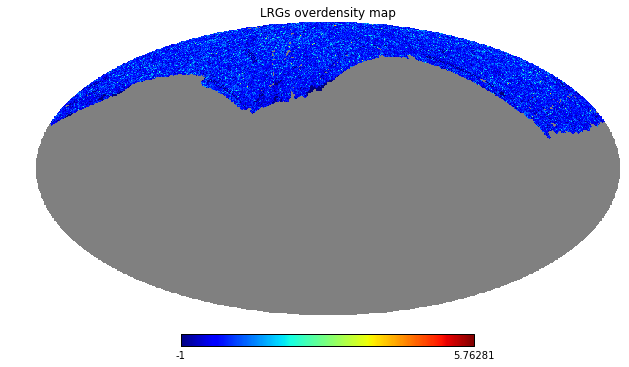

In [17]:
%matplotlib inline
import fitsio
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

#####################################
##            Constants            ##
#####################################
NSIDE = 512
LMAX = 1024
PHI_ROT = 0
ZGT = '070'
PLANEMASKCOVERAGE = 40
MAPFREQ = 857

#####################################
##           Galaxies              ##
#####################################
theta = np.array([])
phi   = np.array([])

for i in xrange(545): ## 545 fits files in total
    fits = fitsio.FITS(FGAL+str(i).zfill(3)+'.fits')
    theta = np.append(theta, fits[1]['dec'][:])
    phi   = np.append(phi,   fits[1]['ra'][:])
    fits.close()

##===  (ra, dec) -> (theta, phi)
theta = (-1)*theta*np.pi/180. + np.pi/2.
phi = phi*np.pi/180. 

##===  Celestial coordinate -> galactic coordinate
rotation = [PHI_ROT, 0.0] ## (phi, theta) in deg.
r_C2G = hp.Rotator(rot=rotation, coord=['C', 'G'])
theta, phi = r_C2G(theta, phi)

#==============  galaxies --> pixel =================
galMap = np.zeros(hp.nside2npix(NSIDE))
galPix = hp.ang2pix(NSIDE, theta, phi)

for pix in galPix:
    galMap[pix] += 1  ## count map

# hp.mollview(galMap, title="LRGs count map")
# plt.show()    

##============= mask out south  ====================
maskHemi =  np.arange(hp.nside2npix(NSIDE))
npixs = len(maskHemi)
for i in xrange(npixs):
    if (i<= npixs/2):
        maskHemi[i] = True
    else:
        maskHemi[i] = False


##============== DR12 CMASS North mask ==============
if PHI_ROT == 0:
    GALMAPMASK = '/Users/jh/Desktop/data/SDSS/mask_DR12v5_CMASS_North_512_galactic_x4.fits'
else:
    GALMAPMASK = "/Users/jh/Desktop/data/SDSS/mask_DR12v5_CMASS_North_512_galactic_x4_rot%i.fits"%(PHI_ROT)
galmapmask = hp.read_map(GALMAPMASK)
galmapmask = galmapmask > GALMAPMASKTHRESHOLD


##============== apply all the masks ===============
# maskPS = hp.read_map(FMAPMASKPS, field=PCFIELD[MAPFREQ], verbose=False).astype(bool) ##field=5 for F857
# maskPlane = hp.read_map(FMAPMASKPLANE, field=PLANEMASKFIELD[PLANEMASKCOVERAGE], verbose=False).astype(bool) 

galmask = np.logical_and(maskHemi, galmapmask)
# pmask = np.logical_and(maskPS, maskPlane)
# galmask = np.logical_and(galmask, pmask)
galMapMasked = hp.ma(galMap)
galMapMasked.mask = np.logical_not(galmask)        
        

##============ count --> overdensity ==================
galMap_Ngal = 0
galMap_Npix = 0  ## keep track of the number of pixels covered
for i in xrange(len(galMapMasked)):
#     if galMapMasked[i] == 0:
#         galMapMasked[i] = hp.UNSEEN
    if galMapMasked[i] != hp.UNSEEN:
        galMap_Ngal+=galMapMasked[i]
        galMap_Npix+=1
        
countMean = float(galMap_Ngal)/galMap_Npix

for i in xrange(len(galMapMasked)):
    if galMapMasked[i] != hp.UNSEEN:
        galMapMasked[i] = (galMapMasked[i] - countMean)/countMean

hp.mollview(galMapMasked, title='LRGs overdensity map')
plt.show()

